## Практикум 2. 
### Класифiкацiя зображень моделями багатошарових перcептронiв у TensorFlow
#### Варіант 8 (Cats_vs_dogs)

In [1]:
# model_1 : 1 sigmoid + SGD
#model_2 : 5 hl tanh + SGD
#model_3 : 5 hl relu + SGD
#model_4 : 5 hl lrelu + SGD
#model_5 : 5 hl Prelu + SGD
#model_6 : 5 hl ELU + SGD
#model_7 : 5 hl ELU + Nesterov
#model_8 : 5 hl ELU + Adagrad
#model_9 : 5 hl ELU + Adadelte
#model_10 : 5 hl ELU + Adam
#model_11 : 5 hl ELU + Adadelte + BN + Dropout
#model_12 : 5 hl ELU + Adadelte + BN + Dropout + l1 + l2 + max
#model_13 : 5 hl ELU + Adadelte + BN + Dropout

In [3]:
import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os 
import datetime
import random
from shutil import copyfile
from keras import backend as K
from keras import initializers, optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import LeakyReLU, PReLU, ELU, BatchNormalization, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.metrics import BinaryAccuracy


warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext tensorboard
plt.rcParams["figure.figsize"] = (16,20)

In [4]:
!del /q %TMP%\.tensorboard-info\*

Графики метрик и лосс для всех моделей

In [6]:
%tensorboard --logdir logs --host localhost

Reusing TensorBoard on port 6006 (pid 16464), started 0:00:57 ago. (Use '!kill 16464' to kill it.)

In [5]:
# F1-score

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**1) Завантажити набiр зображень згiдно з варiантом.**


Данные взяты с https://www.microsoft.com/en-us/download/details.aspx?id=54765

**2) Виконати пiдготовку даних для навчання.**

Удалим изображения на которых нет собак или котов 

cat.3216.jpg, cat.7377.jpg, cat.8456.jpg, cat.7564.jpg, cat.9171.jpg, cat.4688.jpg, cat.5351.jpg, cat.5418.jpg, cat.11184.jpg, dog.1043.jpg, dog.1773.jpg, dog.4367.jpg, dog.8736.jpg, dog.8898.jpg, dog.10237.jpg

изменим разрешение изображений на 128х128<br>
/255 

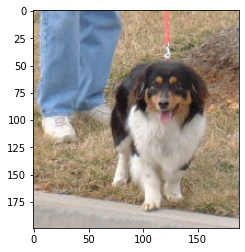

In [6]:
folder = 'data/train/dogs/'
filename = folder + 'dog' + str(2) + '.jpg'
image = imread(filename)
plt.imshow(image)
plt.show()

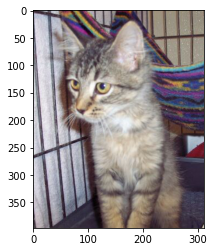

In [7]:
folder = 'data/train/cats/'
filename = folder + 'cat' + str(2) + '.jpg'
image = imread(filename)
plt.imshow(image)
plt.show()

In [8]:
"""folder = 'data/'
photos, labels = list(), list()
for file in tqdm (os.listdir(folder)):
    output = 0.0
    if file.startswith('cat'):
        output = 1.0
    try:
        photo = load_img(folder + file, target_size=(200, 200))
        photo = img_to_array(photo)
        photos.append(photo)
        labels.append(output)
    except:
        pass
    
photos = np.asarray(photos)/255
labels = np.asarray(labels).astype('float32')
np.save('dogs_vs_cats_photos.npy', photos)
np.save('dogs_vs_cats_labels.npy', labels)

photos = np.load('dogs_vs_cats_photos.npy')
labels = np.load('dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)"""

"folder = 'data/'\nphotos, labels = list(), list()\nfor file in tqdm (os.listdir(folder)):\n    output = 0.0\n    if file.startswith('cat'):\n        output = 1.0\n    try:\n        photo = load_img(folder + file, target_size=(200, 200))\n        photo = img_to_array(photo)\n        photos.append(photo)\n        labels.append(output)\n    except:\n        pass\n    \nphotos = np.asarray(photos)/255\nlabels = np.asarray(labels).astype('float32')\nnp.save('dogs_vs_cats_photos.npy', photos)\nnp.save('dogs_vs_cats_labels.npy', labels)\n\nphotos = np.load('dogs_vs_cats_photos.npy')\nlabels = np.load('dogs_vs_cats_labels.npy')\nprint(photos.shape, labels.shape)"

**3) Розбити данi на навчальну i перевiрочну множини у спiввiдношеннi 80%: 20%.**

для загрузки изображений сделаем такую струткуру директорий:
    
data/<br>
....train/<br>
.........cats/<br>
.............catn.jpg<br>
.............catm.jpg<br>
........dogs/<br>
............dogn.jpg<br>
............dogm.jpg<br>
....test/<br>
........cats/<br>
............catn.jpg<br>
............catm.jpg<br>
.......dogs/<br>
............dogn.jpg<br>
............dogm.jpg<br>

In [9]:
"""dataset_home = 'data/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        os.makedirs(newdir, exist_ok=True)"""

"dataset_home = 'data/'\nsubdirs = ['train/', 'test/']\nfor subdir in subdirs:\n    labeldirs = ['dogs/', 'cats/']\n    for labldir in labeldirs:\n        newdir = dataset_home + subdir + labldir\n        os.makedirs(newdir, exist_ok=True)"

In [10]:
"""random.seed(1)
val_ratio = 0.2
src_directory = 'data/'
for file in tqdm(os.listdir(src_directory)):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)"""

"random.seed(1)\nval_ratio = 0.2\nsrc_directory = 'data/'\nfor file in tqdm(os.listdir(src_directory)):\n    src = src_directory + '/' + file\n    dst_dir = 'train/'\n    if random.random() < val_ratio:\n        dst_dir = 'test/'\n    if file.startswith('cat'):\n        dst = dataset_home + dst_dir + 'cats/'  + file\n        copyfile(src, dst)\n    elif file.startswith('dog'):\n        dst = dataset_home + dst_dir + 'dogs/'  + file\n        copyfile(src, dst)"

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

In [8]:
#стохастический 
train = datagen.flow_from_directory('data/train/', color_mode="rgb",
                                       class_mode='binary', batch_size=1, target_size=(128, 128))
test = datagen.flow_from_directory('data/test/', color_mode="rgb",
                                      class_mode='binary', batch_size=1, target_size=(128, 128))

Found 19899 images belonging to 2 classes.
Found 5084 images belonging to 2 classes.


In [12]:
train.image_shape, train.class_indices

((128, 128, 3), {'cats': 0, 'dogs': 1})

**4) Побудувати i навчити базову модель з єдиним вихiдним шаром softmax.
Для створення шару можна використати функцiю tf.layers.dense. 
Ваги iнiцiалiзувати невеликими випадковими значеннями, якi нормально
розподiленi з нульовим середнiм та одиничною дисперсiєю.***

In [13]:
log_dir = "logs/model_1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
model = Sequential()
initializer = initializers.RandomNormal(mean=0.0, stddev=1)
opt = optimizers.SGD(learning_rate=0.01)
model.add(Flatten())
model.add(Dense(1, kernel_initializer=initializer,activation='sigmoid'))
model.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history = model.fit(train, steps_per_epoch=len(train),
    validation_data=test, validation_steps=len(test), epochs=20, verbose=1,callbacks=[tensorboard_callback])

Epoch 1/20
19899/19899 [==============================] - 90s 4ms/step - loss: 33.0372 - accuracy: 0.5250 - f1: 0.2616 - auc: 0.5261 - val_loss: 35.9278 - val_accuracy: 0.5238 - val_f1: 0.4742 - val_auc: 0.5315
Epoch 2/20
19899/19899 [==============================] - 89s 4ms/step - loss: 29.6413 - accuracy: 0.5513 - f1: 0.2770 - auc: 0.5558 - val_loss: 23.0407 - val_accuracy: 0.5425 - val_f1: 0.4414 - val_auc: 0.5470
Epoch 3/20
19899/19899 [==============================] - 89s 4ms/step - loss: 28.0625 - accuracy: 0.5635 - f1: 0.2833 - auc: 0.5636 - val_loss: 23.6791 - val_accuracy: 0.5478 - val_f1: 0.1064 - val_auc: 0.5506
Epoch 4/20
19899/19899 [==============================] - 88s 4ms/step - loss: 26.8570 - accuracy: 0.5734 - f1: 0.2876 - auc: 0.5756 - val_loss: 16.1726 - val_accuracy: 0.5824 - val_f1: 0.2622 - val_auc: 0.5879
Epoch 5/20
19899/19899 [==============================] - 88s 4ms/step - loss: 26.7643 - accuracy: 0.5729 - f1: 0.2916 - auc: 0.5745 - val_loss: 22.0422 - v

**5) Побудувати глибокi моделi з декiлькома скритими шарами ReLU або tanh.**

In [8]:
#возьмеме размер банча 64

train = datagen.flow_from_directory('data/train/', color_mode="rgb",
                                       class_mode='binary', batch_size=64, target_size=(128, 128))
test = datagen.flow_from_directory('data/test/', color_mode="rgb",
                                      class_mode='binary', batch_size=64, target_size=(128, 128))
log_dir = "logs/model_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Found 19899 images belonging to 2 classes.
Found 5084 images belonging to 2 classes.


**6)Моделi iз симетричними функцiями активацiї tanh навчити методом ґрадiєнтного спуску, використовуючи iнiцiалiзацiю ваг Глоро.**

In [16]:
model_2 = Sequential()
initializer = initializers.GlorotUniform()
opt = optimizers.SGD()
model_2.add(Flatten())
model_2.add(Dense(1084, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(408, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(250, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(100, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(60, kernel_initializer=initializer,activation='tanh'))
model_2.add(Dense(1, kernel_initializer=initializer,activation='sigmoid'))
model_2.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_2 = model_2.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                       callbacks=[tensorboard_callback])


Epoch 1/30
311/311 [==============================] - 103s 328ms/step - loss: 0.7126 - accuracy: 0.5286 - f1: 0.4710 - auc: 0.5476 - val_loss: 0.6712 - val_accuracy: 0.5751 - val_f1: 0.4203 - val_auc: 0.6522
Epoch 2/30
311/311 [==============================] - 95s 305ms/step - loss: 0.6577 - accuracy: 0.6039 - f1: 0.5958 - auc: 0.6477 - val_loss: 0.6483 - val_accuracy: 0.6231 - val_f1: 0.6494 - val_auc: 0.6741
Epoch 3/30
311/311 [==============================] - 100s 323ms/step - loss: 0.6440 - accuracy: 0.6250 - f1: 0.6250 - auc: 0.6738 - val_loss: 0.6324 - val_accuracy: 0.6334 - val_f1: 0.6507 - val_auc: 0.6957
Epoch 4/30
311/311 [==============================] - 95s 305ms/step - loss: 0.6299 - accuracy: 0.6447 - f1: 0.6364 - auc: 0.6979 - val_loss: 0.6360 - val_accuracy: 0.6312 - val_f1: 0.6783 - val_auc: 0.7003
Epoch 5/30
311/311 [==============================] - 94s 301ms/step - loss: 0.6291 - accuracy: 0.6416 - f1: 0.6375 - auc: 0.6979 - val_loss: 0.6334 - val_accuracy: 0.638

**7)Моделi iз несиметричними функцiями активацiї ReLU навчити методом
ґрадiєнтного спуску, використовуючи iнiцiалiзацiю ваг Хе.**

In [17]:
log_dir = "logs/model_3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_callbacks = [TensorBoard(log_dir=log_dir, histogram_freq=1),
                ModelCheckpoint(filepath='save/checkpoint/model_3/model.{epoch:02d}-{val_loss:.2f}',
                monitor='val_loss',
                mode='min',
                save_best_only=True)
               ]

Found 19899 images belonging to 2 classes.
Found 5084 images belonging to 2 classes.


тут мы будем сохранять модель с найменьшим значение лосс, после чего прервем обучение, загрузим последнюю модель и продолжим обучение 

In [18]:
model_3 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_3.add(Flatten())
model_3.add(Dense(1084, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(408, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(250, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(100, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(60, kernel_initializer=initializer,activation='relu'))
model_3.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_3.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_3 = model_3.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                       callbacks = my_callbacks)

Epoch 1/30
311/311 [==============================] - 105s 336ms/step - loss: 0.6864 - accuracy: 0.5516 - f1: 0.4763 - auc: 0.5694 - val_loss: 0.6619 - val_accuracy: 0.5917 - val_f1: 0.5128 - val_auc: 0.6531
INFO:tensorflow:Assets written to: save/checkpoint/model_3\model.01-0.66\assets
Epoch 2/30
311/311 [==============================] - 101s 326ms/step - loss: 0.6616 - accuracy: 0.5995 - f1: 0.5916 - auc: 0.6387 - val_loss: 0.6489 - val_accuracy: 0.6216 - val_f1: 0.5804 - val_auc: 0.6784
INFO:tensorflow:Assets written to: save/checkpoint/model_3\model.02-0.65\assets
Epoch 3/30
311/311 [==============================] - 105s 338ms/step - loss: 0.6497 - accuracy: 0.6171 - f1: 0.6191 - auc: 0.6622 - val_loss: 0.6557 - val_accuracy: 0.6111 - val_f1: 0.6586 - val_auc: 0.6638
Epoch 4/30
311/311 [==============================] - 113s 363ms/step - loss: 0.6369 - accuracy: 0.6348 - f1: 0.6263 - auc: 0.6882 - val_loss: 0.6733 - val_accuracy: 0.5785 - val_f1: 0.3477 - val_auc: 0.6808
Epoch 5/

KeyboardInterrupt: 

In [29]:
model_3_load = load_model('save/checkpoint/model_3/model.14-0.61/', compile=False)

проверим, что наши модели совпадают

In [30]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1084)              53281852  
_________________________________________________________________
dense_8 (Dense)              (None, 408)               442680    
_________________________________________________________________
dense_9 (Dense)              (None, 250)               102250    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_11 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [31]:
model_3_load.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1084)              53281852  
_________________________________________________________________
dense_8 (Dense)              (None, 408)               442680    
_________________________________________________________________
dense_9 (Dense)              (None, 250)               102250    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_11 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [32]:
model_3_load.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_31 = model_3_load.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=16, verbose=1,
                       callbacks = my_callbacks)

Epoch 1/16
311/311 [==============================] - 104s 332ms/step - loss: 0.5698 - accuracy: 0.7018 - f1: 0.6856 - auc: 0.7737 - val_loss: 0.7099 - val_accuracy: 0.5826 - val_f1: 0.3549 - val_auc: 0.6963
Epoch 2/16
311/311 [==============================] - 96s 310ms/step - loss: 0.5651 - accuracy: 0.7046 - f1: 0.6941 - auc: 0.7768 - val_loss: 0.6293 - val_accuracy: 0.6475 - val_f1: 0.6590 - val_auc: 0.7040
Epoch 3/16
311/311 [==============================] - 93s 300ms/step - loss: 0.5607 - accuracy: 0.7100 - f1: 0.7067 - auc: 0.7827 - val_loss: 0.6384 - val_accuracy: 0.6452 - val_f1: 0.6029 - val_auc: 0.7072
Epoch 4/16
311/311 [==============================] - 94s 301ms/step - loss: 0.5507 - accuracy: 0.7172 - f1: 0.7061 - auc: 0.7914 - val_loss: 0.6350 - val_accuracy: 0.6422 - val_f1: 0.5632 - val_auc: 0.7183
Epoch 5/16
311/311 [==============================] - 94s 302ms/step - loss: 0.5474 - accuracy: 0.7162 - f1: 0.7103 - auc: 0.7941 - val_loss: 0.6936 - val_accuracy: 0.6308

In [33]:
model_3_load.save("save/full/model_3_load")

INFO:tensorflow:Assets written to: save/full/model_3_load\assets


**9)Пiдiбрати значення гiперпараметра швидкостi навчання. Для вiдображення кривих навчання та вказаних вище графiкiв використати TensorBoard.**

По опытам был выбран дефолтный параметр learning_rate = 0.01

**10) Який метод iнiцiалiзацiї: традицiйний чи Глоро / Хе дає меншi значення
показника accuracy?**

хлоро c фукнцией активации tanh

**11)Чи має мiсце перенавчання побудованих моделей?**

да, примерно после 5-8 эпохи

**13)Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: LeakyReLU,
Parametric LeakyReLU, ELU. Дослiдити як вибiр функцiї активацiї впли-
ває на:**

• час навчання мережi,<br>
• якiсть роботи мережi на перевiрочнiй множинi,<br>
• час надання прогнозу мережею.<br>

In [36]:
log_dir = "logs/model_4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [37]:
model_4 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_4.add(Flatten())
model_4.add(Dense(1084, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(408, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(250, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(100, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(60, kernel_initializer=initializer))
model_4.add(LeakyReLU())
model_4.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_4.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_4 = model_4.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=15, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/15
311/311 [==============================] - 107s 340ms/step - loss: 0.7017 - accuracy: 0.5391 - f1: 0.5073 - auc: 0.5527 - val_loss: 0.6645 - val_accuracy: 0.5964 - val_f1: 0.5422 - val_auc: 0.6458
Epoch 2/15
311/311 [==============================] - 112s 361ms/step - loss: 0.6615 - accuracy: 0.6078 - f1: 0.5932 - auc: 0.6428 - val_loss: 0.6683 - val_accuracy: 0.5895 - val_f1: 0.6744 - val_auc: 0.6642
Epoch 3/15
311/311 [==============================] - 116s 372ms/step - loss: 0.6501 - accuracy: 0.6218 - f1: 0.6159 - auc: 0.6648 - val_loss: 0.6385 - val_accuracy: 0.6302 - val_f1: 0.6261 - val_auc: 0.6866
Epoch 4/15
311/311 [==============================] - 107s 344ms/step - loss: 0.6459 - accuracy: 0.6271 - f1: 0.6186 - auc: 0.6721 - val_loss: 0.6375 - val_accuracy: 0.6308 - val_f1: 0.6598 - val_auc: 0.6898
Epoch 5/15
311/311 [==============================] - 110s 353ms/step - loss: 0.6408 - accuracy: 0.6293 - f1: 0.6263 - auc: 0.6808 - val_loss: 0.6427 - val_accuracy: 0.

In [38]:
history_4 = model_4.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=15, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/15
311/311 [==============================] - 100s 321ms/step - loss: 0.5736 - accuracy: 0.6961 - f1: 0.6868 - auc: 0.7681 - val_loss: 0.6219 - val_accuracy: 0.6560 - val_f1: 0.6435 - val_auc: 0.7148
Epoch 2/15
311/311 [==============================] - 105s 338ms/step - loss: 0.5678 - accuracy: 0.7014 - f1: 0.6896 - auc: 0.7754 - val_loss: 0.6156 - val_accuracy: 0.6475 - val_f1: 0.6685 - val_auc: 0.7207
Epoch 3/15
311/311 [==============================] - 101s 324ms/step - loss: 0.5627 - accuracy: 0.7066 - f1: 0.6954 - auc: 0.7797 - val_loss: 0.6219 - val_accuracy: 0.6528 - val_f1: 0.6718 - val_auc: 0.7201
Epoch 4/15
311/311 [==============================] - 101s 324ms/step - loss: 0.5564 - accuracy: 0.7126 - f1: 0.7033 - auc: 0.7855 - val_loss: 0.6273 - val_accuracy: 0.6501 - val_f1: 0.6806 - val_auc: 0.7219
Epoch 5/15
311/311 [==============================] - 99s 318ms/step - loss: 0.5530 - accuracy: 0.7168 - f1: 0.7076 - auc: 0.7900 - val_loss: 0.6251 - val_accuracy: 0.6

In [39]:
log_dir = "logs/model_5/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
model_5 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_5.add(Flatten())
model_5.add(Dense(1084, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(408, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(250, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(100, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(60, kernel_initializer=initializer))
model_5.add(PReLU())
model_5.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_5.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_5 = model_5.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 100s 316ms/step - loss: 0.6858 - accuracy: 0.5559 - f1: 0.4546 - auc: 0.5742 - val_loss: 0.6699 - val_accuracy: 0.5956 - val_f1: 0.6653 - val_auc: 0.6398
Epoch 2/30
311/311 [==============================] - 98s 314ms/step - loss: 0.6600 - accuracy: 0.6079 - f1: 0.5897 - auc: 0.6447 - val_loss: 0.6475 - val_accuracy: 0.6147 - val_f1: 0.6410 - val_auc: 0.6707
Epoch 3/30
311/311 [==============================] - 94s 304ms/step - loss: 0.6463 - accuracy: 0.6258 - f1: 0.6212 - auc: 0.6715 - val_loss: 0.6444 - val_accuracy: 0.6310 - val_f1: 0.5740 - val_auc: 0.6862
Epoch 4/30
311/311 [==============================] - 94s 303ms/step - loss: 0.6397 - accuracy: 0.6279 - f1: 0.6171 - auc: 0.6816 - val_loss: 0.6357 - val_accuracy: 0.6330 - val_f1: 0.6377 - val_auc: 0.6875
Epoch 5/30
311/311 [==============================] - 94s 303ms/step - loss: 0.6312 - accuracy: 0.6456 - f1: 0.6385 - auc: 0.6965 - val_loss: 0.6312 - val_accuracy: 0.6387

In [41]:
log_dir = "logs/model_6/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [42]:
model_6 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD()
model_6.add(Flatten())
model_6.add(Dense(1084, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(408, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(250, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(100, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(60, kernel_initializer=initializer))
model_6.add(ELU())
model_6.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_6.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_6 = model_6.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 95s 304ms/step - loss: 0.7350 - accuracy: 0.5434 - f1: 0.4326 - auc: 0.5627 - val_loss: 0.6541 - val_accuracy: 0.6096 - val_f1: 0.6480 - val_auc: 0.6576
Epoch 2/30
311/311 [==============================] - 94s 301ms/step - loss: 0.6575 - accuracy: 0.6045 - f1: 0.5916 - auc: 0.6475 - val_loss: 0.6408 - val_accuracy: 0.6233 - val_f1: 0.6475 - val_auc: 0.6821
Epoch 3/30
311/311 [==============================] - 94s 302ms/step - loss: 0.6421 - accuracy: 0.6285 - f1: 0.6273 - auc: 0.6763 - val_loss: 0.6353 - val_accuracy: 0.6267 - val_f1: 0.6612 - val_auc: 0.6921
Epoch 4/30
311/311 [==============================] - 94s 302ms/step - loss: 0.6337 - accuracy: 0.6323 - f1: 0.6182 - auc: 0.6894 - val_loss: 0.6321 - val_accuracy: 0.6332 - val_f1: 0.6509 - val_auc: 0.6925
Epoch 5/30
311/311 [==============================] - 98s 316ms/step - loss: 0.6261 - accuracy: 0.6448 - f1: 0.6382 - auc: 0.7021 - val_loss: 0.6293 - val_accuracy: 0.6361 

быстрее всех тренеровалась и давала предсказание ELU, дольше всех LRELU<br>
лучшие результаты показала ELU, худший LRELU<br>

**14) Замiсть методу ґрадiєнтного спуску використати один з адаптивних методiв:<br>
прискорений градiєнт Нестерова<br>
Adagrad<br>
Adadelta<br>
Adam<br>
ваги iнiцiалiзувати наведеними вище способами. Побудувати аналогiчнi графiки змiни значень функцiї втрат та змiни показника accuracy.**

In [9]:
log_dir = "logs/model_7_Nest/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
model_7 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.SGD(nesterov=True,momentum=0.9)
model_7.add(Flatten())
model_7.add(Dense(1084, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(408, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(250, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(100, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(60, kernel_initializer=initializer))
model_7.add(ELU())
model_7.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_7.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_7 = model_7.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 119s 381ms/step - loss: 1.1138 - accuracy: 0.4946 - f1: 0.3705 - auc: 0.4952 - val_loss: 0.6946 - val_accuracy: 0.5018 - val_f1: 0.0000e+00 - val_auc: 0.5151
Epoch 2/30
311/311 [==============================] - 111s 357ms/step - loss: 0.6955 - accuracy: 0.5148 - f1: 0.4048 - auc: 0.5155 - val_loss: 0.6906 - val_accuracy: 0.5252 - val_f1: 0.5513 - val_auc: 0.5277
Epoch 3/30
311/311 [==============================] - 101s 324ms/step - loss: 0.6900 - accuracy: 0.5348 - f1: 0.4462 - auc: 0.5447 - val_loss: 0.6873 - val_accuracy: 0.5566 - val_f1: 0.6694 - val_auc: 0.5956
Epoch 4/30
311/311 [==============================] - 104s 335ms/step - loss: 0.6818 - accuracy: 0.5619 - f1: 0.5833 - auc: 0.5789 - val_loss: 0.6662 - val_accuracy: 0.6019 - val_f1: 0.6553 - val_auc: 0.6362
Epoch 5/30
311/311 [==============================] - 105s 338ms/step - loss: 0.6664 - accuracy: 0.5946 - f1: 0.6090 - auc: 0.6281 - val_loss: 0.6653 - val_accuracy

In [11]:
log_dir = "logs/model_8_Adagrad/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model_8 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adagrad()
model_8.add(Flatten())
model_8.add(Dense(1084, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(408, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(250, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(100, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(60, kernel_initializer=initializer))
model_8.add(ELU())
model_8.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_8.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_8 = model_8.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 104s 330ms/step - loss: 0.7075 - accuracy: 0.5535 - f1: 0.5169 - auc: 0.5729 - val_loss: 0.6659 - val_accuracy: 0.5832 - val_f1: 0.4556 - val_auc: 0.6581
Epoch 2/30
311/311 [==============================] - 104s 334ms/step - loss: 0.6517 - accuracy: 0.6190 - f1: 0.6232 - auc: 0.6604 - val_loss: 0.6447 - val_accuracy: 0.6306 - val_f1: 0.5838 - val_auc: 0.6854
Epoch 3/30
311/311 [==============================] - 103s 332ms/step - loss: 0.6424 - accuracy: 0.6230 - f1: 0.6241 - auc: 0.6751 - val_loss: 0.6324 - val_accuracy: 0.6373 - val_f1: 0.6331 - val_auc: 0.6947
Epoch 4/30
311/311 [==============================] - 108s 347ms/step - loss: 0.6219 - accuracy: 0.6481 - f1: 0.6471 - auc: 0.7071 - val_loss: 0.6353 - val_accuracy: 0.6239 - val_f1: 0.6773 - val_auc: 0.7020
Epoch 5/30
311/311 [==============================] - 101s 325ms/step - loss: 0.6234 - accuracy: 0.6446 - f1: 0.6429 - auc: 0.7061 - val_loss: 0.6437 - val_accuracy: 0.

In [13]:
log_dir = "logs/model_9_Adadel/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
model_9 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adadelta()
model_9.add(Flatten())
model_9.add(Dense(1084, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(408, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(250, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(100, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(60, kernel_initializer=initializer))
model_9.add(ELU())
model_9.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_9.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_9 = model_9.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 113s 359ms/step - loss: 0.6926 - accuracy: 0.5401 - f1: 0.5014 - auc: 0.5571 - val_loss: 0.6621 - val_accuracy: 0.6141 - val_f1: 0.5600 - val_auc: 0.6565
Epoch 2/30
311/311 [==============================] - 109s 351ms/step - loss: 0.6639 - accuracy: 0.6019 - f1: 0.5821 - auc: 0.6379 - val_loss: 0.6531 - val_accuracy: 0.6094 - val_f1: 0.6575 - val_auc: 0.6713
Epoch 3/30
311/311 [==============================] - 109s 352ms/step - loss: 0.6502 - accuracy: 0.6204 - f1: 0.6249 - auc: 0.6648 - val_loss: 0.6425 - val_accuracy: 0.6239 - val_f1: 0.6228 - val_auc: 0.6786
Epoch 4/30
311/311 [==============================] - 109s 351ms/step - loss: 0.6412 - accuracy: 0.6281 - f1: 0.6253 - auc: 0.6798 - val_loss: 0.6365 - val_accuracy: 0.6306 - val_f1: 0.6346 - val_auc: 0.6883
Epoch 5/30
311/311 [==============================] - 109s 351ms/step - loss: 0.6371 - accuracy: 0.6317 - f1: 0.6260 - auc: 0.6849 - val_loss: 0.6400 - val_accuracy: 0.

In [15]:
log_dir = "logs/model_10_Adam/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
model_10 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adam()
model_10.add(Flatten())
model_10.add(Dense(1084, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(408, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(250, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(100, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(60, kernel_initializer=initializer))
model_10.add(ELU())
model_10.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),activation='sigmoid'))
model_10.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_10 = model_10.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 115s 366ms/step - loss: 3.7248 - accuracy: 0.5107 - f1: 0.3835 - auc: 0.5066 - val_loss: 0.6590 - val_accuracy: 0.6121 - val_f1: 0.5910 - val_auc: 0.6550
Epoch 2/30
311/311 [==============================] - 110s 354ms/step - loss: 0.7233 - accuracy: 0.5566 - f1: 0.4511 - auc: 0.5829 - val_loss: 0.6636 - val_accuracy: 0.5885 - val_f1: 0.4361 - val_auc: 0.6682
Epoch 3/30
311/311 [==============================] - 112s 358ms/step - loss: 0.6540 - accuracy: 0.6110 - f1: 0.5989 - auc: 0.6555 - val_loss: 0.6427 - val_accuracy: 0.6353 - val_f1: 0.6031 - val_auc: 0.6858
Epoch 4/30
311/311 [==============================] - 105s 338ms/step - loss: 0.6456 - accuracy: 0.6242 - f1: 0.6141 - auc: 0.6715 - val_loss: 0.6858 - val_accuracy: 0.5858 - val_f1: 0.3492 - val_auc: 0.6867
Epoch 5/30
311/311 [==============================] - 112s 359ms/step - loss: 0.6348 - accuracy: 0.6338 - f1: 0.6198 - auc: 0.6877 - val_loss: 0.6326 - val_accuracy: 0.

**15) Чи покращилася якiсть навчання при використаннi адаптивного алгоритму оптимiзацiї?**

лучше всех показал себя алгоритм Ададельта

**16) Для однiєї з мереж додати нормалiзацiю за мiнi-батчами перед кожним шаром**

In [18]:
model_11 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adadelta(learning_rate=0.1)
model_11.add(Flatten())
model_11.add(BatchNormalization())
model_11.add(Dense(1084, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(408, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(250, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(100, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(60, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(1, kernel_initializer=initializers.GlorotUniform()))
model_11.add(BatchNormalization())
model_11.add(Activation('sigmoid'))
model_11.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_11 = model_11.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=5, verbose=1,)
                      #callbacks=[tensorboard_callback] )

Epoch 1/5
311/311 [==============================] - 151s 477ms/step - loss: 0.6862 - accuracy: 0.5973 - f1: 0.6014 - auc: 0.6365 - val_loss: 0.6182 - val_accuracy: 0.6562 - val_f1: 0.6570 - val_auc: 0.7133
Epoch 2/5
311/311 [==============================] - 135s 435ms/step - loss: 0.5875 - accuracy: 0.6852 - f1: 0.6836 - auc: 0.7536 - val_loss: 0.6151 - val_accuracy: 0.6526 - val_f1: 0.6462 - val_auc: 0.7167
Epoch 3/5
311/311 [==============================] - 135s 435ms/step - loss: 0.5448 - accuracy: 0.7346 - f1: 0.7314 - auc: 0.8088 - val_loss: 0.6175 - val_accuracy: 0.6552 - val_f1: 0.6267 - val_auc: 0.7143
Epoch 4/5
311/311 [==============================] - 140s 449ms/step - loss: 0.5028 - accuracy: 0.7766 - f1: 0.7745 - auc: 0.8571 - val_loss: 0.6073 - val_accuracy: 0.6619 - val_f1: 0.6569 - val_auc: 0.7278
Epoch 5/5
311/311 [==============================] - 136s 436ms/step - loss: 0.4678 - accuracy: 0.8128 - f1: 0.8102 - auc: 0.8914 - val_loss: 0.6183 - val_accuracy: 0.6538 

In [19]:
history_11 = model_11.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=5, verbose=1,)
                      #callbacks=[tensorboard_callback] )

Epoch 1/5
311/311 [==============================] - 148s 476ms/step - loss: 0.4337 - accuracy: 0.8385 - f1: 0.8372 - auc: 0.9168 - val_loss: 0.6180 - val_accuracy: 0.6517 - val_f1: 0.6475 - val_auc: 0.7163
Epoch 2/5
311/311 [==============================] - 145s 466ms/step - loss: 0.3995 - accuracy: 0.8658 - f1: 0.8649 - auc: 0.9395 - val_loss: 0.6223 - val_accuracy: 0.6485 - val_f1: 0.6361 - val_auc: 0.7142
Epoch 3/5
311/311 [==============================] - 146s 468ms/step - loss: 0.3639 - accuracy: 0.8952 - f1: 0.8942 - auc: 0.9594 - val_loss: 0.6311 - val_accuracy: 0.6524 - val_f1: 0.6415 - val_auc: 0.7086
Epoch 4/5
311/311 [==============================] - 140s 451ms/step - loss: 0.3341 - accuracy: 0.9131 - f1: 0.9121 - auc: 0.9713 - val_loss: 0.6383 - val_accuracy: 0.6387 - val_f1: 0.6355 - val_auc: 0.7029
Epoch 5/5
311/311 [==============================] - 142s 458ms/step - loss: 0.3023 - accuracy: 0.9324 - f1: 0.9316 - auc: 0.9818 - val_loss: 0.6546 - val_accuracy: 0.6450 

модель очень быстро учится на тренеровочном множестве а тест отстает(увеличение батча и измениние momentum не помогло)

**17) Додати до моделей один/ декiлька шарiв дропауту. Пiдiбрати значення p - iмовiрностi вiдключення нейронiв.**

In [20]:
log_dir = "logs/model_11/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
model_11 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adadelta(learning_rate=.1)
model_11.add(Flatten())
model_11.add(BatchNormalization())
model_11.add(Dropout(0.8))
model_11.add(Dense(1084, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dropout(0.5))
model_11.add(Dense(408, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dropout(0.5))
model_11.add(Dense(250, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dropout(0.5))
model_11.add(Dense(100, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dropout(0.2))
model_11.add(Dense(60, kernel_initializer=initializer))
model_11.add(BatchNormalization())
model_11.add(ELU())
model_11.add(Dense(1, kernel_initializer=initializers.GlorotUniform()))
model_11.add(BatchNormalization())
model_11.add(Activation('sigmoid'))
model_11.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_11 = model_11.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=30, verbose=1,
                      callbacks=[tensorboard_callback] )

Epoch 1/30
311/311 [==============================] - 164s 521ms/step - loss: 0.7092 - accuracy: 0.5751 - f1: 0.5680 - auc: 0.6077 - val_loss: 0.6804 - val_accuracy: 0.6151 - val_f1: 0.6463 - val_auc: 0.6737
Epoch 2/30
311/311 [==============================] - 181s 582ms/step - loss: 0.6495 - accuracy: 0.6253 - f1: 0.6185 - auc: 0.6728 - val_loss: 0.6423 - val_accuracy: 0.6338 - val_f1: 0.6368 - val_auc: 0.6912
Epoch 3/30
311/311 [==============================] - 165s 530ms/step - loss: 0.6332 - accuracy: 0.6385 - f1: 0.6331 - auc: 0.6925 - val_loss: 0.6277 - val_accuracy: 0.6459 - val_f1: 0.6533 - val_auc: 0.7029
Epoch 4/30
311/311 [==============================] - 165s 530ms/step - loss: 0.6175 - accuracy: 0.6607 - f1: 0.6547 - auc: 0.7164 - val_loss: 0.6288 - val_accuracy: 0.6387 - val_f1: 0.6407 - val_auc: 0.7012
Epoch 5/30
311/311 [==============================] - 177s 568ms/step - loss: 0.6163 - accuracy: 0.6602 - f1: 0.6521 - auc: 0.7174 - val_loss: 0.6159 - val_accuracy: 0.

**18) Реалiзувати ще один спосiб регуляризацiї мереж - ранню зупинку навчання мережi.**

In [25]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=4, mode="max")

In [26]:
history_11 = model_11.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=15, verbose=1,
                      callbacks=[early_stop] )

Epoch 1/15
311/311 [==============================] - 154s 495ms/step - loss: 0.5558 - accuracy: 0.7153 - f1: 0.7042 - auc: 0.7864 - val_loss: 0.6061 - val_accuracy: 0.6664 - val_f1: 0.6662 - val_auc: 0.7330
Epoch 2/15
311/311 [==============================] - 153s 491ms/step - loss: 0.5549 - accuracy: 0.7136 - f1: 0.7035 - auc: 0.7863 - val_loss: 0.6123 - val_accuracy: 0.6709 - val_f1: 0.6628 - val_auc: 0.7318
Epoch 3/15
311/311 [==============================] - 155s 497ms/step - loss: 0.5499 - accuracy: 0.7168 - f1: 0.7054 - auc: 0.7921 - val_loss: 0.6080 - val_accuracy: 0.6719 - val_f1: 0.6595 - val_auc: 0.7334
Epoch 4/15
311/311 [==============================] - 155s 499ms/step - loss: 0.5417 - accuracy: 0.7272 - f1: 0.7176 - auc: 0.7994 - val_loss: 0.6091 - val_accuracy: 0.6701 - val_f1: 0.6702 - val_auc: 0.7362
Epoch 5/15
311/311 [==============================] - 154s 495ms/step - loss: 0.5421 - accuracy: 0.7246 - f1: 0.7159 - auc: 0.7992 - val_loss: 0.6153 - val_accuracy: 0.

**19) Обмежити ваги мережi, застосовуючи регуляризацiю за l1, l2 та max нормами.**

увеличим значение батчей до 128, так как модель очень долго учится

In [95]:
train = datagen.flow_from_directory('data/train/', color_mode="rgb",
                                       class_mode='binary', batch_size=128, target_size=(128, 128))
test = datagen.flow_from_directory('data/test/', color_mode="rgb",
                                      class_mode='binary', batch_size=128, target_size=(128, 128))

Found 19899 images belonging to 2 classes.
Found 5084 images belonging to 2 classes.


In [97]:
model_12 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adadelta(0.1)
model_12.add(Flatten())
model_12.add(BatchNormalization())
model_12.add(Dropout(0.8))
model_12.add(Dense(1084, kernel_initializer=initializer, 
                  kernel_regularizer=regularizers.l2(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_12.add(BatchNormalization())
model_12.add(ELU())
model_12.add(Dropout(0.5))
model_12.add(Dense(408, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l2(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_12.add(BatchNormalization())
model_12.add(ELU())
model_12.add(Dropout(0.5))
model_12.add(Dense(256, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l2(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_12.add(BatchNormalization())
model_12.add(ELU())
model_12.add(Dropout(0.5))
model_12.add(Dense(120, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l1(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_12.add(BatchNormalization())
model_12.add(ELU())
model_12.add(Dropout(0.2))
model_12.add(Dense(64, kernel_initializer=initializer,
                   kernel_regularizer=regularizers.l1(1e-6),
                  kernel_constraint=max_norm(1),
                  ))
model_12.add(BatchNormalization())
model_12.add(ELU())
model_12.add(Dense(1, kernel_initializer=initializers.GlorotUniform(),
                   kernel_regularizer=regularizers.l1(1e-6),
                  kernel_constraint=max_norm(1)
                  ))
model_12.add(BatchNormalization())
model_12.add(Activation('sigmoid'))
model_12.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_12 = model_12.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=10, verbose=1,)
                    #  callbacks=[tensorboard_callback] )

Epoch 1/10
156/156 [==============================] - 199s 1s/step - loss: 0.7201 - accuracy: 0.5687 - f1: 0.5738 - auc: 0.6001 - val_loss: 0.6995 - val_accuracy: 0.6066 - val_f1: 0.6693 - val_auc: 0.6748
Epoch 2/10
156/156 [==============================] - 189s 1s/step - loss: 0.6562 - accuracy: 0.6221 - f1: 0.6288 - auc: 0.6718 - val_loss: 0.6649 - val_accuracy: 0.6231 - val_f1: 0.6515 - val_auc: 0.6877
Epoch 3/10
156/156 [==============================] - 188s 1s/step - loss: 0.6392 - accuracy: 0.6430 - f1: 0.6459 - auc: 0.6939 - val_loss: 0.6349 - val_accuracy: 0.6424 - val_f1: 0.6503 - val_auc: 0.7042
Epoch 4/10
156/156 [==============================] - 188s 1s/step - loss: 0.6260 - accuracy: 0.6493 - f1: 0.6496 - auc: 0.7092 - val_loss: 0.6253 - val_accuracy: 0.6434 - val_f1: 0.6482 - val_auc: 0.7110
Epoch 5/10
156/156 [==============================] - 188s 1s/step - loss: 0.6217 - accuracy: 0.6567 - f1: 0.6503 - auc: 0.7154 - val_loss: 0.6226 - val_accuracy: 0.6481 - val_f1: 

In [98]:
history_12 = model_12.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=20, verbose=1,)
                    #  callbacks=[tensorboard_callback] )

Epoch 1/20
156/156 [==============================] - 188s 1s/step - loss: 0.6021 - accuracy: 0.6748 - f1: 0.6636 - auc: 0.7395 - val_loss: 0.6116 - val_accuracy: 0.6579 - val_f1: 0.6573 - val_auc: 0.7261
Epoch 2/20
156/156 [==============================] - 187s 1s/step - loss: 0.5981 - accuracy: 0.6786 - f1: 0.6664 - auc: 0.7447 - val_loss: 0.6143 - val_accuracy: 0.6627 - val_f1: 0.6605 - val_auc: 0.7233
Epoch 3/20
156/156 [==============================] - 187s 1s/step - loss: 0.5941 - accuracy: 0.6840 - f1: 0.6729 - auc: 0.7505 - val_loss: 0.6132 - val_accuracy: 0.6585 - val_f1: 0.6522 - val_auc: 0.7246
Epoch 4/20
156/156 [==============================] - 202s 1s/step - loss: 0.5893 - accuracy: 0.6885 - f1: 0.6763 - auc: 0.7556 - val_loss: 0.6142 - val_accuracy: 0.6570 - val_f1: 0.6468 - val_auc: 0.7226
Epoch 5/20
156/156 [==============================] - 214s 1s/step - loss: 0.5941 - accuracy: 0.6855 - f1: 0.6748 - auc: 0.7497 - val_loss: 0.6108 - val_accuracy: 0.6566 - val_f1: 

# final model

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

In [291]:
train = datagen.flow_from_directory('data/train/', color_mode="rgb",
                                       class_mode='binary', batch_size=64, target_size=(128, 128))
test = datagen.flow_from_directory('data/test/', color_mode="rgb",
                                      class_mode='binary', batch_size=64, target_size=(128, 128))

Found 19899 images belonging to 2 classes.
Found 5084 images belonging to 2 classes.


In [290]:
my_callbacks = [ModelCheckpoint(filepath='save/checkpoint/model_13/model.{epoch:02d}-{val_loss:.4f}',monitor='val_loss',
                mode='min',
                save_best_only=True),
                EarlyStopping(monitor="val_loss", patience=5, mode="min")
               ]

In [105]:
model_13 = Sequential()
initializer = initializers.GlorotNormal()
opt = optimizers.Adadelta(learning_rate=.1)
model_13.add(Flatten())
model_13.add(BatchNormalization())
model_13.add(Dropout(0.8))
model_13.add(Dense(1084, kernel_initializer=initializer))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.5))
model_13.add(Dense(408, kernel_initializer=initializer))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.5))
model_13.add(Dense(256, kernel_initializer=initializer))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.5))
model_13.add(Dense(120, kernel_initializer=initializer))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dropout(0.2))
model_13.add(Dense(64, kernel_initializer=initializer))
model_13.add(BatchNormalization())
model_13.add(ELU())
model_13.add(Dense(1, kernel_initializer=initializers.GlorotUniform()))
model_13.add(BatchNormalization())
model_13.add(Activation('sigmoid'))
model_13.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
history_13 = model_13.fit(train, steps_per_epoch=len(train),
                              validation_data=test, validation_steps=len(test), epochs=50, verbose=1,
                      callbacks=[my_callbacks] )

Epoch 1/50
311/311 [==============================] - 164s 519ms/step - loss: 0.7130 - accuracy: 0.5686 - f1: 0.5701 - auc: 0.6023 - val_loss: 0.6626 - val_accuracy: 0.6245 - val_f1: 0.6414 - val_auc: 0.6823
INFO:tensorflow:Assets written to: save/checkpoint/model_13\model.01-0.66\assets
Epoch 2/50
311/311 [==============================] - 152s 488ms/step - loss: 0.6552 - accuracy: 0.6183 - f1: 0.6171 - auc: 0.6652 - val_loss: 0.6364 - val_accuracy: 0.6359 - val_f1: 0.6415 - val_auc: 0.6947
INFO:tensorflow:Assets written to: save/checkpoint/model_13\model.02-0.64\assets
Epoch 3/50
311/311 [==============================] - 153s 490ms/step - loss: 0.6335 - accuracy: 0.6437 - f1: 0.6415 - auc: 0.6934 - val_loss: 0.6223 - val_accuracy: 0.6456 - val_f1: 0.6417 - val_auc: 0.7088
INFO:tensorflow:Assets written to: save/checkpoint/model_13\model.03-0.62\assets
Epoch 4/50
311/311 [==============================] - 155s 497ms/step - loss: 0.6263 - accuracy: 0.6489 - f1: 0.6426 - auc: 0.7033 - 

In [11]:
opt = optimizers.Adadelta(learning_rate=.1)

In [9]:
model_13_load = load_model('save/checkpoint/model_13/model.02-0.6017/', compile=False)

**20) Обрати найкращу модель за метриками якостi F1 (f1-score) та AUC.**


AUC: model_11 : 5 hl ELU + Adadelte + BN + Dropout

F1 : model_11 : 5 hl ELU + Adadelte + BN + Dropout

loss : model_11 : 5 hl ELU + Adadelte + BN + Dropout

Accuracy: model_11 : 5 hl ELU + Adadelte + BN + Dropout

**21) Використати обрану модель для розпiзнавання одного iз зображень перевiрочної множини.**


In [283]:
train.class_indices

{'cats': 0, 'dogs': 1}

In [11]:
test = []
for i in range(1,22):
    test.append(img_to_array(load_img(f'test/{i}.jpg', target_size=(128, 128)))/255)


In [12]:
np.array(test).shape

(21, 128, 128, 3)

In [13]:
#model_13_load.compile(loss = "binary_crossentropy", metrics = ["accuracy", f1, "AUC"], optimizer = opt)
model_13_load.predict(np.array(test), batch_size=21, verbose=1)

1/1 [==============================] - 0s 452ms/step


array([[0.47489536],
       [0.17474881],
       [0.26288423],
       [0.6463791 ],
       [0.24962422],
       [0.6475421 ],
       [0.30727732],
       [0.40801233],
       [0.6800232 ],
       [0.10645664],
       [0.7357888 ],
       [0.22290865],
       [0.43221897],
       [0.71080554],
       [0.10461006],
       [0.5962166 ],
       [0.8673128 ],
       [0.50797087],
       [0.750291  ],
       [0.3217473 ],
       [0.88481706]], dtype=float32)

In [14]:
predict = model_13_load.predict_classes(np.array(test), batch_size=21, verbose=1)

1/1 [==============================] - 0s 37ms/step


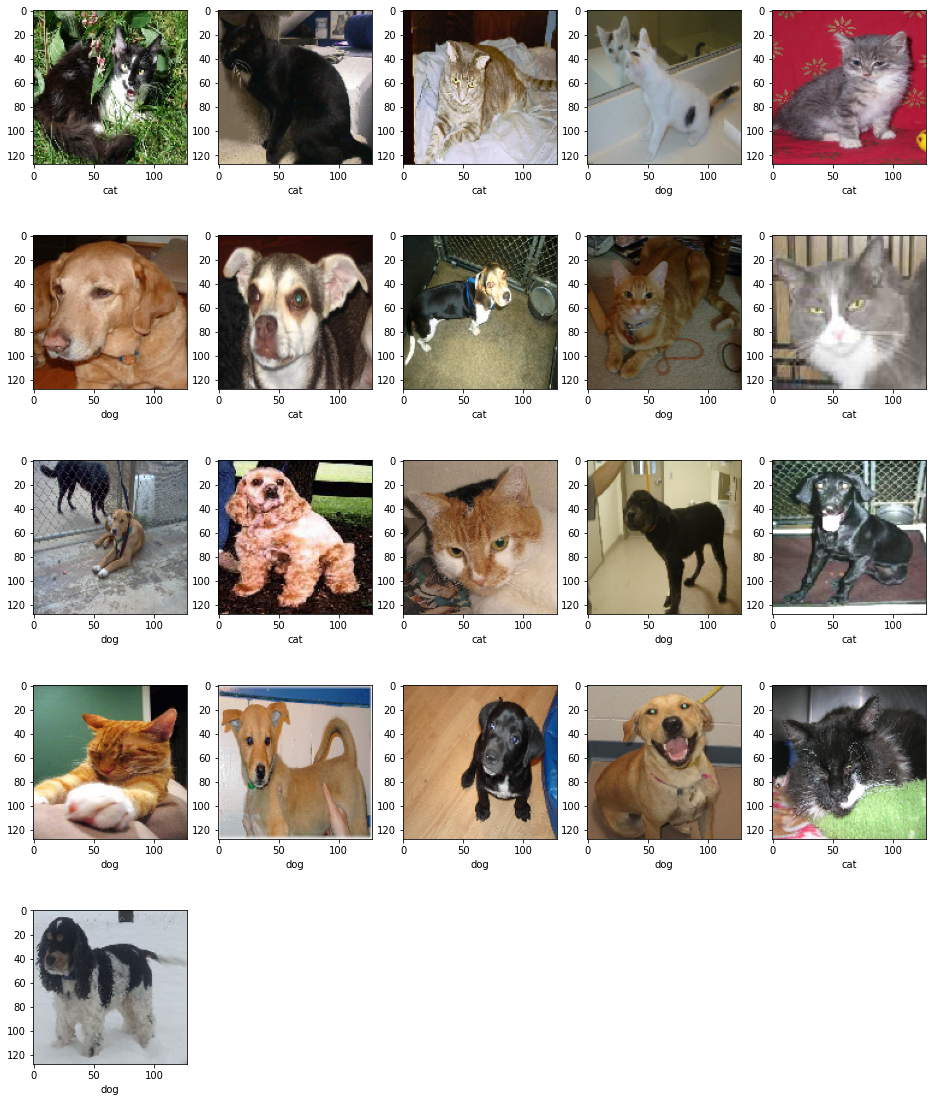

In [15]:
for i in range(len(test)):
    plt.subplot(5,5,1+i)
    plt.imshow(test[i])
    if predict[i] ==0:
        plt.xlabel('cat')
    else:
        plt.xlabel('dog')
plt.show()

0.675...